# Task Overview

In this task, your goal is to verify the impact of data noise level in neural network training.
You should use MLP architecture trained on MNIST dataset (like in previous lab exercises).


We will experiment with two setups:
1. Pick X. Take X% of training examples and reassign their labels to random ones. Note that we don't change anything in the test set.
2. Pick X. During each training step, for each sample, change values of X% randomly selected pixels to random values. Note that we don't change anything in the test set.

For both setups, check the impact of various levels of noise (various values of X%) on model performance. Show plots comparing crossentropy (log-loss) and accuracy with varying X%, and also comparing two setups with each other.
Prepare short report briefly explaining the results and observed trends. Consider questions like "why accuracy/loss increases/decreases so quickly/slowly", "why Z is higher in setup 1/2" and any potentially surprising things you see on charts.

### Potential questions, clarifications
* Q: Can I still use sigmoid/MSE loss?
  * You should train your network with softmax and crossentropy loss (log-loss), especially since you should report crossentropy loss.
* Q: When I pick X% of pixels/examples, does it have to be exactly X% or can it be X% in expectation?
  * A: It's fine either way.
* Q: When I randomize pixels, should I randomize them again each time a particular example is drawn (each training step/epoch) or only once before training?
  * A: Each training step/epoch.
* Q: When I randomize labels, should I randomize them again each time a particular example is drawn (each training step/epoch) or only once before training?
  * A: Only once before training.
* Q: What is the expected length of report/explanation?
  * A: There is no minimum/maximum, but between 5 (concise) and 20 sentences should be good. Don't forget about plots.
* Q: When I replace labels/pixels with random values, what random distribution should I use?
  * A: A distribution reasonably similar to the data. However, you don't need to match dataset's distribution exactly - approximation will be totally fine, especially if it's faster or easier to get.
* Q: Can I use something different than Colab/Jupyter Notebook? E.g. just Python files.
  * A: Yes, although notebook is encouraged; please include in you solution code and pdf.

# Model definition and training.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn import init
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

In [3]:
class MnistTrainer(object):
    def __init__(self, batch_size, label_noise=False, X=5):
        transform = transforms.Compose(
                [transforms.ToTensor()])
        self.trainset = torchvision.datasets.MNIST(
            root='./data',
            download=True,
            train=True,
            transform=transform)
        
        if label_noise:
            n = len(self.trainset)
            n_change = int(X/100 * n)   # how many labels to change
            change_ids = np.random.choice(n, n_change, replace=False)
            new_labels = np.random.randint(10, size=n_change)
            self.trainset.targets[change_ids] = torch.from_numpy(new_labels)

        self.trainloader = torch.utils.data.DataLoader(
            self.trainset, batch_size=batch_size, shuffle=True, num_workers=2)

        self.testset = torchvision.datasets.MNIST(
            root='./data',
            train=False,
            download=True, transform=transform)
        self.testloader = torch.utils.data.DataLoader(
            self.testset, batch_size=1, shuffle=False, num_workers=2)

    def train(self, epochs=10, pixel_noise=False, X=5):
        net = Net()

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9)

        accuracies = []
        losses = []

        if pixel_noise:
            noise = self.trainset.data / 255
            noise = np.random.permutation(noise.flatten())
            noise = noise[:int(X/100 * len(noise))]

        for epoch in range(epochs):
            running_loss = 0.0
            total_loss = 0.0
            start = 0

            for i, data in enumerate(self.trainloader, 0):
                inputs, labels = data

                if pixel_noise:
                    s = inputs.shape
                    inputs = inputs.flatten()
                    n = len(inputs)
                    n_change = int(X/100 * n)
                    change_ids = np.random.choice(n, n_change, replace=False)
                    stop = start + n_change
                    new_pixels = noise[start:stop]
                    inputs[change_ids] = torch.from_numpy(new_pixels)
                    inputs = torch.reshape(inputs, s)
                    start = stop
                    
                optimizer.zero_grad()

                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                if i % 100 == 99:
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 100))
                    total_loss += running_loss
                    running_loss = 0.0
            total_loss /= i 
            print('total loss:', total_loss)
            losses.append(total_loss)
            correct = 0
            total = 0
            with torch.no_grad():
                for data in self.testloader:
                    images, labels = data
                    outputs = net(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            acc = 100 * correct / total
            print('Accuracy of the network on the {} test images: {} %'.format(
                total, acc))
            accuracies.append(acc)
        return accuracies, losses

# Training models in setup 1: with randomized labels.

In [4]:
Xs = [0, 5, 10, 20, 40]
accuracies, losses = [], []
for X in Xs:
    trainer = MnistTrainer(batch_size=256, label_noise=True, X=X)
    accs, loss = trainer.train(epochs=10)
    accuracies.append(accs)
    losses.append(loss)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

[1,   100] loss: 0.951
[1,   200] loss: 0.303
total loss: 0.5359751808847117
Accuracy of the network on the 10000 test images: 93.4 %
[2,   100] loss: 0.199
[2,   200] loss: 0.161
total loss: 0.15374505252410203
Accuracy of the network on the 10000 test images: 95.0 %
[3,   100] loss: 0.127
[3,   200] loss: 0.116
total loss: 0.10352854551667841
Accuracy of the network on the 10000 test images: 96.81 %
[4,   100] loss: 0.093
[4,   200] loss: 0.085
total loss: 0.07602629142725824
Accuracy of the network on the 10000 test images: 97.0 %
[5,   100] loss: 0.070
[5,   200] loss: 0.069
total loss: 0.05952116550129448
Accuracy of the network on the 10000 test images: 97.04 %
[6,   100] loss: 0.059
[6,   200] loss: 0.063
total loss: 0.051844591481818095
Accuracy of the network on the 10000 test images: 97.68 %
[7,   100] loss: 0.048
[7,   200] loss: 0.048
total loss: 0.04113676422076602
Accuracy of the network on the 100

# Training models in setup 2: with randomized pixels.

In [5]:
accuracies2, losses2 = [], []
for X in Xs:
    trainer = MnistTrainer(batch_size=256)
    accs, loss = trainer.train(epochs=10, pixel_noise=True, X=X)
    accuracies2.append(accs)
    losses2.append(loss)

[1,   100] loss: 0.970
[1,   200] loss: 0.306
total loss: 0.5451887499572884
Accuracy of the network on the 10000 test images: 93.33 %
[2,   100] loss: 0.205
[2,   200] loss: 0.175
total loss: 0.16261699751146838
Accuracy of the network on the 10000 test images: 95.71 %
[3,   100] loss: 0.128
[3,   200] loss: 0.118
total loss: 0.10502741143553175
Accuracy of the network on the 10000 test images: 96.69 %
[4,   100] loss: 0.094
[4,   200] loss: 0.087
total loss: 0.07738030458299014
Accuracy of the network on the 10000 test images: 96.72 %
[5,   100] loss: 0.071
[5,   200] loss: 0.075
total loss: 0.062093692139173165
Accuracy of the network on the 10000 test images: 97.31 %
[6,   100] loss: 0.060
[6,   200] loss: 0.063
total loss: 0.05275697416315476
Accuracy of the network on the 10000 test images: 97.41 %
[7,   100] loss: 0.050
[7,   200] loss: 0.052
total loss: 0.04384048034349441
Accuracy of the network on the 10000 test images: 97.63 %
[8,   100] loss: 0.041
[8,   200] loss: 0.042
to

In [15]:
trainer = MnistTrainer(batch_size=256)
accs60, loss60 = trainer.train(epochs=20, pixel_noise=True, X=60)

[1,   100] loss: 1.713
[1,   200] loss: 0.797
total loss: 1.0724481410450406
Accuracy of the network on the 10000 test images: 89.18 %
[2,   100] loss: 0.696
[2,   200] loss: 0.645
total loss: 0.5734138371598008
Accuracy of the network on the 10000 test images: 91.85 %
[3,   100] loss: 0.585
[3,   200] loss: 0.550
total loss: 0.4849935026250334
Accuracy of the network on the 10000 test images: 93.99 %
[4,   100] loss: 0.504
[4,   200] loss: 0.486
total loss: 0.42305167375976205
Accuracy of the network on the 10000 test images: 94.27 %
[5,   100] loss: 0.467
[5,   200] loss: 0.459
total loss: 0.3956783553983411
Accuracy of the network on the 10000 test images: 95.07 %
[6,   100] loss: 0.433
[6,   200] loss: 0.436
total loss: 0.3715452092070865
Accuracy of the network on the 10000 test images: 95.11 %
[7,   100] loss: 0.412
[7,   200] loss: 0.415
total loss: 0.35322713756408447
Accuracy of the network on the 10000 test images: 95.62 %
[8,   100] loss: 0.397
[8,   200] loss: 0.395
total l

# Plots and report.

In [6]:
trainset = torchvision.datasets.MNIST(root='./data', download=True, train=True)

### Model in setup 1: with randomized labels

Labels are distributed almost uniformly so for this model I decided to redraw X% of the labels from descrete uniform distribution over {0, ..., 9}.  
When a label is randomly selected, there is a 0.1 probability that the new label will be the same as the original label. I decided not to redraw labels in this case. So keep in mind that the actual level of noise is approximately 10% lower than X (for example for X=30% the expected level of actual noise is 27%).

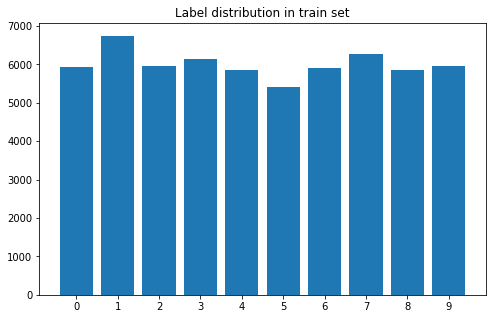

In [7]:
plt.figure(figsize=(8,5))
plt.bar(*np.unique(trainset.targets, return_counts=True))
plt.xticks(range(10))
plt.title('Label distribution in train set')
plt.show()

As expected, log-loss on training set grows with growing value of X (it's impossible for the model to predict the random labels).  
Adding a small percent of noise (5-10%) to the labels doesn't have much impact on the accuracy of the model, it reaches around 97.5%.  
Model with 40% of noise behaves noticeably worse than models with lower level of noise but what's interesting is that it still reaches 96% of accuracy on the test set.

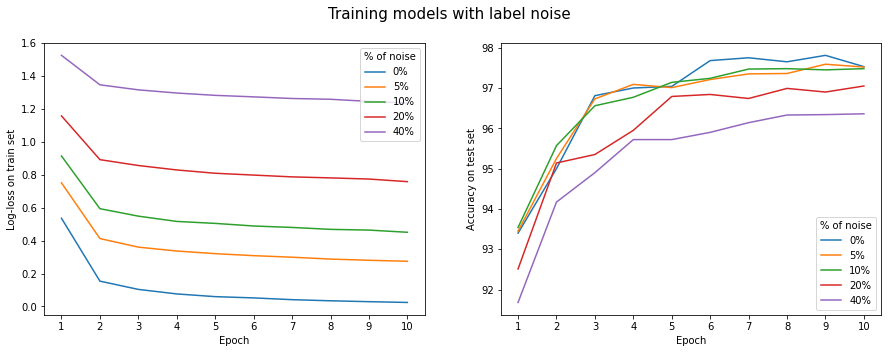

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
for accs, loss, X in zip(accuracies, losses, Xs):
    ax[0].plot(range(1,11), loss, label=str(X)+'%')
    ax[1].plot(range(1,11), accs, label=str(X)+'%')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Log-loss on train set')
ax[0].legend(title='% of noise')
ax[0].set_xticks(range(1,11))
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy on test set')
ax[1].legend(title='% of noise')
ax[1].set_xticks(range(1,11))
plt.suptitle('Training models with label noise', size=15)
plt.show()

### Model in setup 2: with randomized pixels

Distribution of the pixels doesn't resemble any of the basic distributions so for this model I decided to draw random pixels directly from the training dataset.

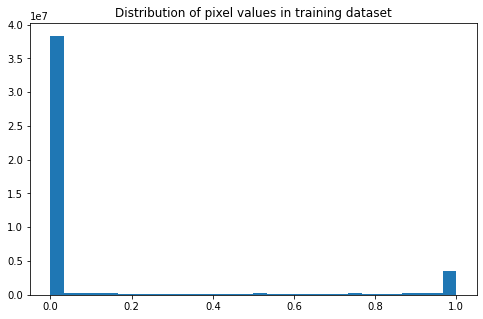

In [12]:
data = trainset.data.flatten() / 255
plt.figure(figsize=(8,5))
plt.hist(data, bins=30)
plt.title('Distribution of pixel values in training dataset')
plt.show()

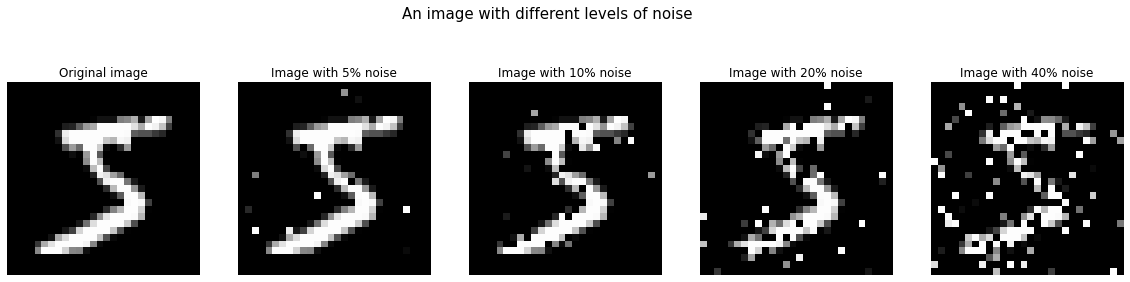

In [13]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
input = trainset.data[0] / 255
axes[0].imshow(input, cmap='gray')
axes[0].set_title('Original image')
axes[0].set_axis_off()
s = input.shape
input = input.flatten()
n = len(input)
i = 1
for X in [5, 10, 20, 40]:
    n_change = int(X/100 * n)
    change_ids = np.random.choice(n, n_change, replace=False)
    new_pixels = np.random.choice(data, n_change)
    with_noise = input.detach().clone()
    with_noise[change_ids] = torch.from_numpy(new_pixels)
    axes[i].imshow(torch.reshape(with_noise, s), cmap='gray')
    axes[i].set_title('Image with {}% noise'.format(X))
    axes[i].set_axis_off()
    i += 1
plt.suptitle('An image with different levels of noise', size=15)
plt.show()

Log-loss on the training set grows with growing value of X but the differences aren't very big.  
Adding noise to pixels of the training dataset actually slightly improves the prediction. Models with 5-20% noise reach 98% accuracy. Adding noise to the data while training acts as a form of regularization and prevents overfitting.  
With a higher level of noise (40%), the model learns slower but eventually reaches the same accuracy as the model without any noise.

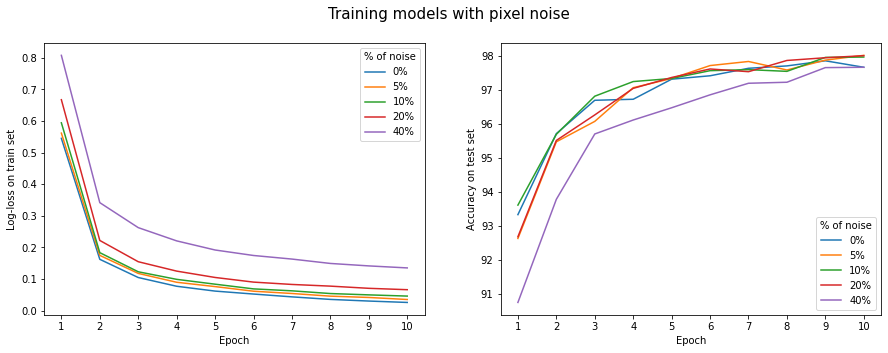

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
for accs, loss, X in zip(accuracies2, losses2, Xs):
    ax[0].plot(range(1,11), loss, label=str(X)+'%')
    ax[1].plot(range(1,11), accs, label=str(X)+'%')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Log-loss on train set')
ax[0].legend(title='% of noise')
ax[0].set_xticks(range(1,11))
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy on test set')
ax[1].legend(title='% of noise')
ax[1].set_xticks(range(1,11))
plt.suptitle('Training models with pixel noise', size=15)
plt.show()

Seeing how well the 40% model learned, I decided to train a model with 60% of pixel noise. I trained it for 20 epochs instead of 10. Its accuracy is lower than accuracies for the previous models but it is still quite impressive - it reaches 97%.

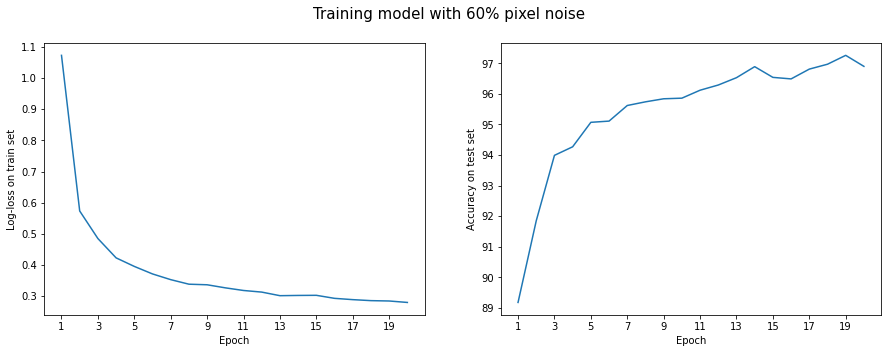

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(range(1,21), loss60)
ax[1].plot(range(1,21), accs60)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Log-loss on train set')
ax[0].set_xticks(range(1,21, 2))
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy on test set')
ax[1].set_xticks(range(1,21, 2))
plt.suptitle('Training model with 60% pixel noise', size=15)
plt.show()

### Summary
Adding a small noise to the labels (around 5-10%) doesn't change the accuracy on test set. The model is still able to learn the properties of the data and predict correctly. Adding a noise to the pixels can actually help the model, similarly to data augmentation.  
It is impressive that even with a very high level of noise (40% for label noise and 60% for pixel noise), the neural network is still able to learn well, with accuracy around 96-97%. It suggests that the data on which we train the models doesn't have to be perfect, it may contain some errors and noise. If we have enough data and computational resources, we are probably able to train a good model.